# Assignment 2.2: Scene-Dependent Image Segmentation

The goal of this homework is to implement a model that seperates foreground and background objects for a specific scene.  
We will use the highway scene from the Change Detection dataset:  
http://jacarini.dinf.usherbrooke.ca/dataset2014#

![input image](highway/input/in001600.jpg "Title") ![gt image](highway/groundtruth/gt001600.png "Title")

## Task 1: Create a custom (Pytorch) dataset


https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
You need to create a class that inherets from **from torch.utils.data.Dataset** and implements two methods:
- **def \_\_len\_\_(self)**:  returns the length of the dataset
- **def \_\_getitem\_\_(self, idx)**: given an integer idx returns the data x,y
    - x is the image as a float tensor of shape: $(3,H,W)$ 
    - y is the label image as a mask of shape: $(H,W)$ each pixel should contain the label 0 (background) or 1 (foreground). It is recommended to use the type torch.long
    
**Tips**:
- The first 470 images are not labeled. Just ignore these images. 
- If possible load all images into memory or even directly to GPU to increase speed.
- You can change the resolution to fit your model or your memory
- Add data augmentation to increase the data size and model robustness

Loaded Dataset
Train Size: 984
Test Size: 246
1
2
3
4


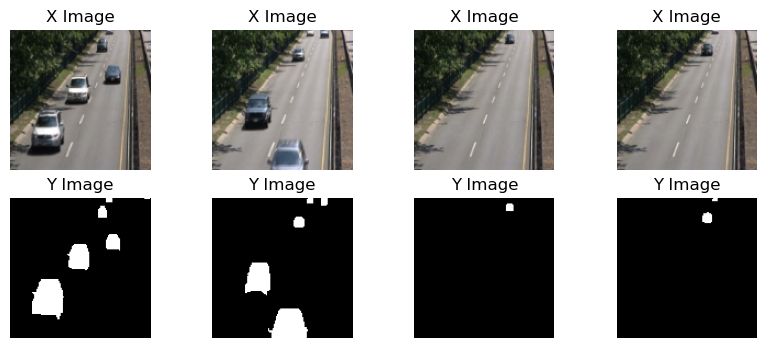

In [41]:
# Imports
import torch
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu, sigmoid
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from PIL import Image
import numpy as np
from scipy.stats import pearsonr

"""
Setting up the HighwayImageDataset Class
"""
class HighwayImageDataset(Dataset):
    def __init__(self, img_x_dir, img_y_dir, y_threshold=200, transform=None, target_transform=None):
        self.img_x_dir = img_x_dir
        self.img_y_dir = img_y_dir
        self.x_filenames = sorted(os.listdir(img_x_dir))
        self.y_filenames = sorted(os.listdir(img_y_dir))
        self.y_threshold = y_threshold
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.x_filenames)
    
    def __getitem__(self, idx):
        x_path = os.path.join(self.img_x_dir, self.x_filenames[idx])
        y_path = os.path.join(self.img_y_dir, self.y_filenames[idx])
        
        x_image = Image.open(x_path).convert("RGB")
        
        y_image = Image.open(y_path).convert("L")
        y_image = y_image.point( lambda p: 255 if p > self.y_threshold else 0 )
        y_image = y_image.convert('1')
        
        if self.transform:
            x_image = self.transform(x_image)
        
        if self.target_transform:
            y_image = self.target_transform(y_image)
        
        return x_image, y_image
    
    
"""
Actually loading the data
"""
x_dir = "highway/input"
y_dir = "highway/groundtruth"

# Very Small image sizes for testing
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = HighwayImageDataset(x_dir, y_dir, transform=transform, target_transform=target_transform)

# Train-test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and testing
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print("Loaded Dataset")
print("Train Size: " + str(len(train_dataset)))
print("Test Size: " + str(len(test_dataset)))

# Show some samples
figure = plt.figure(figsize=(10, 4))
cols, rows = 4, 2
for i in range(1, cols+1):
    print(i)
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img_x, img_y = train_dataset[sample_idx]
    
    figure.add_subplot(rows, cols, i)
    plt.title("X Image")
    plt.axis("off")
    permuted_x_img = img_x.permute(1,2,0)
    plt.imshow(permuted_x_img)
        
    figure.add_subplot(rows, cols, cols + i)
    plt.axis("off")
    plt.title("Y Image")
    permuted_y_img = img_y.permute(1,2,0)
    plt.imshow(permuted_y_img, cmap="gray")
        
plt.show()

## Task 2: Create a custom Segmentation Model

- input: a batch of images $(B,3,H,W)$ 
- output: a batch of pixel-wise class predictions $(B,C,H,W)$, where $C=2$

Tips:
- It is recommended to use a Fully-Convolutional Neural Network, because it flexible to the input and output resolution.
- Use Residual Blocks with convolutional layers.
- Base your model on established segmentation models:
    - U-Net: https://arxiv.org/abs/1505.04597
    - Deeplab: https://arxiv.org/abs/1606.00915

In [2]:
"""
Initializing the U-Net Model
Source: https://towardsdatascience.com/cook-your-first-u-net-in-pytorch-b3297a844cf3
Change: Added Sigmoid Function in the end
"""

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)
        
        
    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)
        #out = relu(out)
        out = sigmoid(out)

        return out

## Task 3: Create a training loop
- split data into training and test data, e.g. 80% training data and 20% test data using your custom dataset.
- Create a Dataloader for your custom datasets 
- Define a training loop for a single epoch:
    - forward pass
    - Loss function, e.g. cross entropy
    - optimizer 
    - backward pass
    - logging
- Define validation loop:
    - forward pass
    - extract binary labels, e.g. threshold or argmax for each pixel.
    - compute evaluation metrics: Accuracy, Precision, Recall and Intersection over Union for each image

In [3]:
# Check for GPU availability and move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
#device = "cpu"

#Initialize the model, loss function, and optimizer
model = UNet(1)
model.to(device)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for segmentation
optimizer = optim.Adam(model.parameters(), lr=0.001)

# For Chart
training_losses = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for x_batch, y_batch in train_dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        #print(outputs.shape)
        #print(y_batch.shape)
        #break
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss/len(train_dataloader)
    training_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}')

Using device: cuda
Epoch 1/10, Loss: 0.20334081030715773
Epoch 2/10, Loss: 0.0321340790222876
Epoch 3/10, Loss: 0.025643898857515154
Epoch 4/10, Loss: 0.018493220308507845
Epoch 5/10, Loss: 0.016227319475066494
Epoch 6/10, Loss: 0.013270625241698955
Epoch 7/10, Loss: 0.03768069888237954
Epoch 8/10, Loss: 0.01843163686590572
Epoch 9/10, Loss: 0.012948863266974808
Epoch 10/10, Loss: 0.01157795350498906


## Task 4: Small Report of your model and training
- visualize training and test error over each epoch
- report the evaluation metrics of the final model

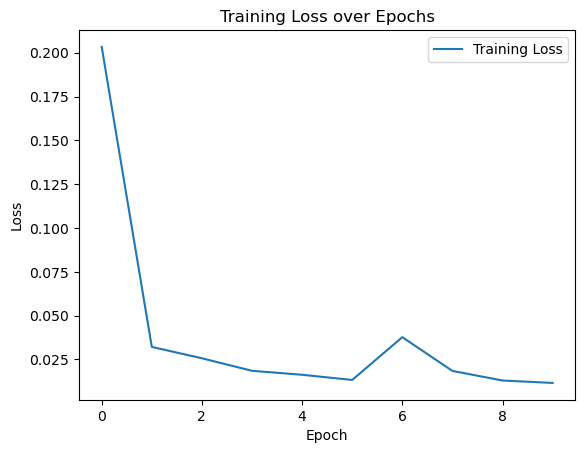

In [4]:
# Plotting the epoch losses
plt.plot(training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [9]:
# Saving the trained model
torch.save(model.state_dict(), "model/unet_epoch10.pth")

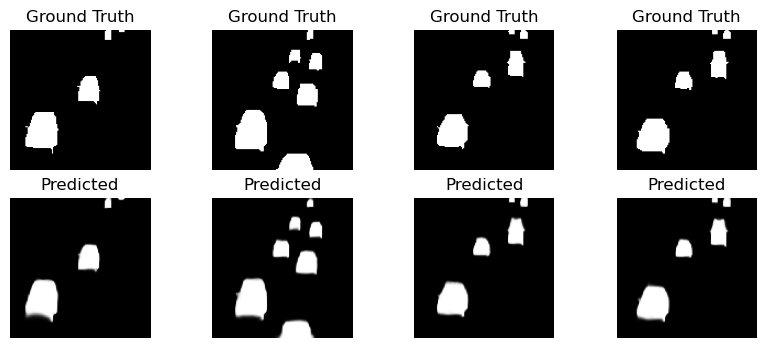

In [55]:
# Evaluate the model
model.eval()

# On a single image for testing
#image = Image.open("highway/input/in000915.jpg" ).convert("RGB")
#image_tensor = transform(image).unsqueeze(0).to(device)
#with torch.no_grad():
#    output = model(image_tensor)
#output_image = output.squeeze(0).cpu().numpy()
#plt.imshow(output_image[0], cmap="gray")
#plt.show()

figure = plt.figure(figsize=(10, 4))
cols, rows = 4, 2
with torch.no_grad():
    for i in range(1, cols+1):
        sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
        img_x, img_y = train_dataset[sample_idx]
        img_x = img_x.unsqueeze(0).to(device)
        output = model(img_x)
        output_image = output.squeeze(0).cpu().numpy()
        
        figure.add_subplot(rows, cols, i)
        plt.title("Ground Truth")
        plt.axis("off")
        permuted_y_true = img_y.permute(1,2,0)
        plt.imshow(permuted_y_true, cmap="gray")
            
        figure.add_subplot(rows, cols, cols + i)
        plt.axis("off")
        plt.title("Predicted")
        permuted_y_pred = output_image.transpose(1,2,0)
        plt.imshow(permuted_y_pred, cmap="gray")
        
plt.show()

In [20]:
"""
Actually measuring the performance
"""

def pixel_accuracy(y_pred, y_true):
    y_pred = y_pred > 0.5
    y_true = y_true > 0.5
    correct = (y_pred == y_true).sum().item()
    total = torch.numel(y_pred)
    return correct / total

model.eval()

total_loss = 0.0
total_accuracy = 0.0

with torch.no_grad():  # Disable gradient computation
    for x_batch, y_batch in test_dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)  # Forward pass
        loss = criterion(outputs, y_batch)  # Compute loss
        total_loss += loss.item()  # Accumulate loss
        total_accuracy += pixel_accuracy(outputs, y_batch)  # Accumulate accuracy
        
        # Correlations (Loop trough each image in the batch)
        for i in range(outputs.size(0)):
            y_pred = outputs[i].cpu().numpy()
            y_true = y_batch[i].cpu().numpy()
 
# Calculate averages
loss = total_loss / len(test_dataloader)
accuracy = total_accuracy / len(test_dataloader)

print (f'(BCE) Loss: {loss}')
print (f'(Pixel) Accuracy: {accuracy}')

(BCE) Loss: 0.011104700363977182
(Pixel) Accuracy: 0.9952737131426411
